<a href="https://colab.research.google.com/github/Ashritha0848/NLP/blob/main/2403A52229%2CAssignment_5_4%2CNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv("/content/Tweets.csv")
df = df[['text', 'airline_sentiment']]
df.head()


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [2]:
tweets = df['text']
labels = df['airline_sentiment']


In [3]:
import re

def clean_tweet(text):
    text = re.sub(r"http\S+|www\S+", "", text)   # URLs
    text = re.sub(r"@\w+", "", text)             # Mentions
    text = re.sub(r"#\w+", "", text)             # Hashtags (text removed here)
    text = re.sub(r"[^\w\s]", "", text)          # Emojis & punctuation
    return text.lower()

df['clean_text'] = df['text'].apply(clean_tweet)


In [5]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

df['tokens'] = df['clean_text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

df['tokens'] = df['tokens'].apply(
    lambda x: [word for word in x if word not in stop_words]
)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

df['lemmas'] = df['tokens'].apply(
    lambda x: [lemmatizer.lemmatize(word) for word in x]
)


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
df['processed_tweet'] = df['lemmas'].apply(lambda x: " ".join(x))
final_nltk_df = df[['processed_tweet', 'airline_sentiment']]
final_nltk_df.head()


,processed_tweet,airline_sentiment
0,said,neutral
1,plus youve added commercial experience tacky,positive
2,didnt today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainmen...,negative
4,really big bad thing,negative


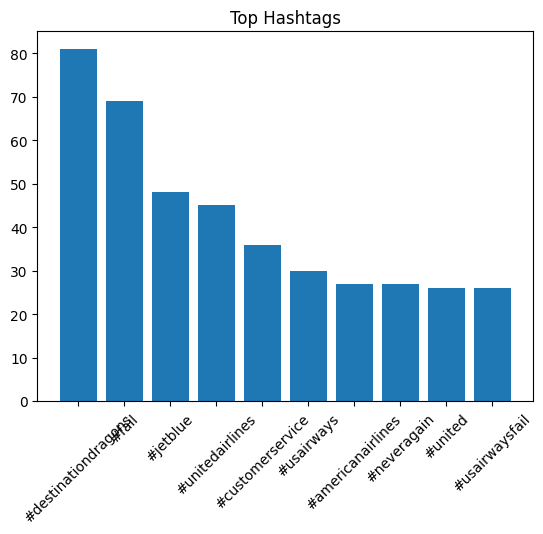

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

hashtags = df['text'].apply(lambda x: re.findall(r"#\w+", x.lower()))
all_hashtags = sum(hashtags, [])

freq = Counter(all_hashtags).most_common(10)

tags, counts = zip(*freq)
plt.bar(tags, counts)
plt.xticks(rotation=45)
plt.title("Top Hashtags")
plt.show()


In [10]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [11]:
def clean_text_spacy(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    return text

df['clean_text_spacy'] = df['text'].apply(clean_text_spacy)


In [15]:
from spacy.tokens import Doc
from spacy.language import Language

@Language.component("hashtag_component")
def hashtag_component(doc):
    hashtags = [token.text for token in doc if token.text.startswith("#")]
    doc._.hashtags = hashtags
    return doc

Doc.set_extension("hashtags", default=[], force=True)

nlp.add_pipe("hashtag_component", last=True)

<function __main__.hashtag_component(doc)>

In [16]:
docs = list(nlp.pipe(df['clean_text_spacy']))


In [17]:
df['lemmas_spacy'] = [
    [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    for doc in docs
]

df['pos_tags'] = [
    [token.pos_ for token in doc if not token.is_stop and token.is_alpha]
    for doc in docs
]


In [18]:
df['processed_spacy'] = df['lemmas_spacy'].apply(lambda x: " ".join(x))
final_spacy_df = df[['processed_spacy', 'airline_sentiment']]
final_spacy_df.head()


,processed_spacy,airline_sentiment
0,say,neutral
1,plus add commercial experience tacky,positive
2,today mean need trip,neutral
3,aggressive blast obnoxious entertainment guest...,negative
4,big bad thing,negative


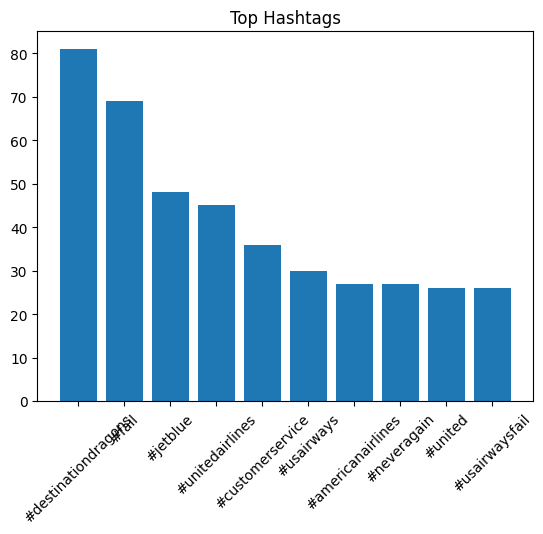

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

hashtags = df['text'].apply(lambda x: re.findall(r"#\w+", x.lower()))
all_hashtags = sum(hashtags, [])

freq = Counter(all_hashtags).most_common(10)

tags, counts = zip(*freq)
plt.bar(tags, counts)
plt.xticks(rotation=45)
plt.title("Top Hashtags")
plt.show()


In [20]:
df['processed_spacy'] = df['lemmas_spacy'].apply(lambda x: " ".join(x))
final_spacy_df = df[['processed_spacy', 'airline_sentiment']]
final_spacy_df.head()

,processed_spacy,airline_sentiment
0,say,neutral
1,plus add commercial experience tacky,positive
2,today mean need trip,neutral
3,aggressive blast obnoxious entertainment guest...,negative
4,big bad thing,negative
